## PSD of BaroData

In [1]:
import matplotlib.pyplot as plt
import os

from obspy import UTCDateTime, read, Stream, Trace, read_inventory
# from scipy.signal import welch
# from numpy import log10, zeros, append, linspace, mean, median, array, where, transpose, shape, histogram
# from pandas import DataFrame, concat, Series, date_range, to_pickle, read_csv
# from pathlib import Path
# from andbro__load_FURT_stream import __load_furt_streamn


import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
# tbeg, tend = UTCDateTime("2023-09-03"), UTCDateTime("2023-09-07")
tbeg, tend = UTCDateTime("2023-09-17"), UTCDateTime("2023-09-25")


## time of inlet below gravel
t_gravel = UTCDateTime("2023-09-20 12:00")

# IROMY DATA

2 Trace(s) in Stream:
BW.FFBI..BDO | 2023-09-17T00:00:00.004999Z - 2023-09-25T00:00:00.004999Z | 40.0 Hz, 27648001 samples (masked)
BW.FFBI..BDF | 2023-09-17T00:00:00.004999Z - 2023-09-25T00:00:00.004999Z | 40.0 Hz, 27648001 samples


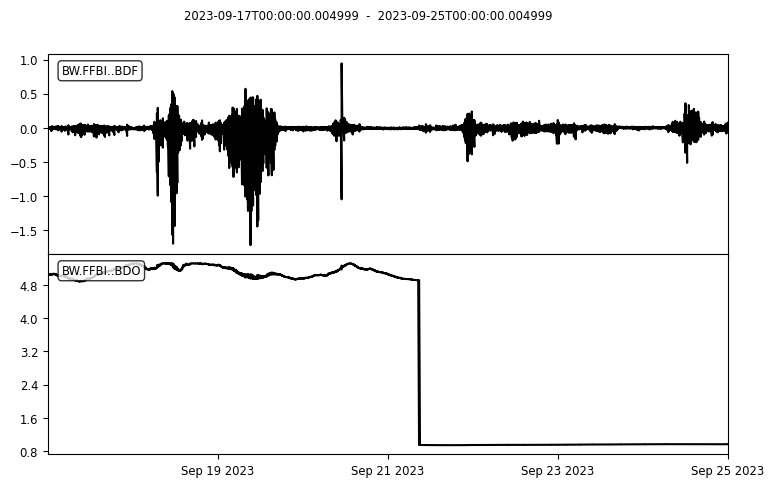

In [4]:
from andbro__read_sds import __read_sds
from obspy import read_inventory

## period to check data... one sided differential signals...
# tbeg, tend = "2023-08-13","2023-08-20"
# ffbi = __read_sds("/import/kilauea-data/LNM2/mb2000/sds/", "BW.IROMY..BD*", tbeg, tend)

ffbi = __read_sds("/bay200/mseed_online/archive/", "BW.FFBI..BD*", tbeg, tend)

ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")

ffbi = ffbi.remove_sensitivity(ffbi_inv)

## remove gain and sensitivity
# for tr in ffbi:
#     if "DF" in tr.stats.channel:
#         tr.data = tr.data /1.0 /6.28099e5 /0.02  # gain=1 sensitivity_reftek=6.28099e5cou/nt/V; sensitivity_mb2005=0.02 VPa
#     elif "DI" in tr.stats.channel:
#         tr.data = tr.data /1.0 /6.28099e5 /1e-3  # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 1 mV/hPa
#     elif "DO" in tr.stats.channel:
#         tr.data = tr.data /1.0 /6.28099e5 /100e-3   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 100 mV/hPa

ffbi.merge()

print(ffbi)

ffbi.plot(equal_scale=False);

## PROMY Data

In [5]:
archive_path+"romy_archive/"

'/import/freenas-ffb-01-data/romy_archive/'

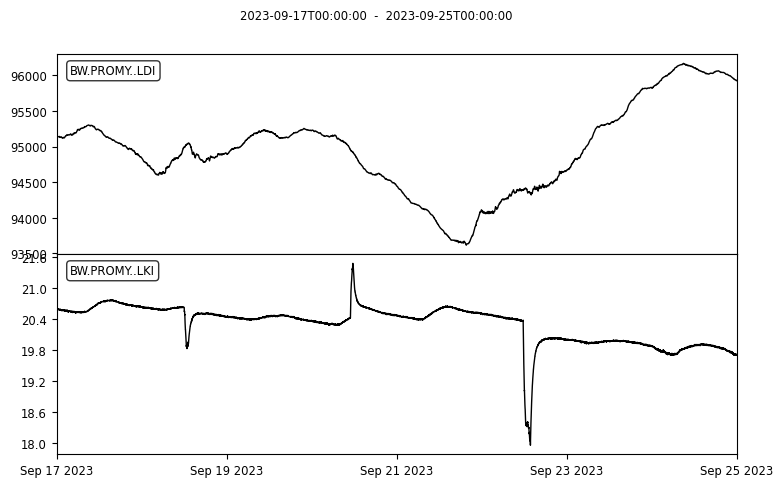

In [6]:
promy = __read_sds(archive_path+"romy_archive/", "BW.PROMY..L*", tbeg, tend)

promy.plot(equal_scale=False);

# FURT Data

In [7]:
from andbro__load_FURT_stream import __load_furt_stream

In [8]:
# %load ~/andbro_python/andbro__load_FURT_stream.py
#!/bin/python3

def __load_furt_stream(starttime, endtime, show_raw=False, sampling_rate=1.0, path_to_archive = '/bay200/gif_online/FURT/WETTER/'):

    '''
    Load a selection of data of FURT weather station for certain times and return an obspy stream


    PARAMETERS:
        - config:    configuration dictionary
        - show_raw:  bool (True/False) -> shows raw data FURT head


    RETURN:
        - stream

    EXAMPLE:
    >>> __load_furt_stream(config, show_raw=False, path_to_archive = '/bay200/gif_online/FURT/WETTER/')

    '''

    from pathlib import Path
    from obspy import UTCDateTime
    from tqdm.notebook import tqdm_notebook
    from numpy import arange, ones, nan
    from obspy import Stream
    from pandas import concat, to_datetime, read_csv, DataFrame

    def __add_trace(cha, tbeg, dat, dt=1):

        from obspy import Trace, UTCDateTime
        from numpy import array

        tr = Trace()
        tr.stats.station = 'FURT'
        tr.stats.network = 'BW'
        tr.stats.channel = str(cha)
        tr.stats.sampling_rate = 1/dt
        tr.stats.starttime = UTCDateTime(tbeg)
        tr.data = array(dat)

        return tr

    def __resample(df, freq='1S'):

        ## make column with datetime
        df['datetime'] = df['date'].astype(str).str.rjust(6,"0")+" "+df['time'].astype(str).str.rjust(6,"0")

        ## drop datetime duplicates
        df = df[df.duplicated("datetime", keep="first") != True]

        ## convert to pandas datetime object
        df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="coerce")

        ## set datetime column as index
        df.set_index('datetime', inplace=True)

        ## remove duplicates
        df = df[~df.index.duplicated()]

        ## resample
        df = df.asfreq(freq=freq)

        return df


    starttime = UTCDateTime(starttime)
    endtime = UTCDateTime(endtime)

    output_text = []

    new_delta = 1/sampling_rate

    if not Path(path_to_archive).exists():
        output_text.append(f"  -> Path: {path_to_archive}, does not exist!")
#         print(f"  -> Path: {path_to_archive}, does not exists!")
        return


    ## declare empyt dataframe
    df = DataFrame()

    for i, date in enumerate(arange(starttime.date, (endtime+86400+10).date)):

        date = UTCDateTime(str(date)).date
        filename = f'FURT.WSX.D.{str(date.day).rjust(2,"0")}{str(date.month).rjust(2,"0")}{str(date.year).rjust(2,"0")[-2:]}.0000'

        if show_raw:
            df0 = read_csv(path_to_archive+filename)
            print(df0.columns.tolist())

        try:
            try:
                try:
                    df0 = read_csv(path_to_archive+filename, header=0, usecols=[0,1,5,8,10,12,13,14], names=['date', 'time', 'Dm', 'Sm', 'T', 'H', 'P','Rc'])
                except:
                    df0 = read_csv(path_to_archive+filename, usecols=[0,1,5,8,10,12,13,14], names=['date', 'time', 'Dm', 'Sm', 'T', 'H', 'P','Rc'])
            except:
                print(f" -> loading of {filename} failed!")



            ## substitute strings with floats

            ## __________________________________________
            ## air temperature Ta in degree C
            # try:
                # df0['T']  = [float(str(str(t).split("=")[1]).split("C")[0]) for t in df0['T']]
            # except:
            #     df0['T'] = ones(len(df0['T']))*nan
            #     print(f" -> {filename}: subsituted T with nan...")

            TT = ones(len(df0['T']))*nan
            for _n, t in enumerate(df0['T']):
                try:
                    TT[_n] = float(str(str(t).split("=")[1]).split("C")[0])
                except:
                    # print(t)
                    continue
            df0['T'] = TT

            ## __________________________________________
            ## air pressure Pa in hPa

            PP = ones(len(df0['P']))*nan
            for _n, p in enumerate(df0['P']):
                try:
                    PP[_n] = float(str(str(p).split("=")[1]).split("H")[0])
                except:
                    # print(p)
                    continue
            df0['P'] = PP

            ## __________________________________________
            # ## relative humiditiy Ua in %RH

            HH = ones(len(df0['H']))*nan
            for _n, h in enumerate(df0['H']):
                try:
                    HH[_n] = float(str(str(h).split("=")[1]).split("P")[0])
                except:
                    # print(h)
                    continue
            df0['H'] = HH

            ## __________________________________________
            # ## rain accumulation in mm

            Rc = ones(len(df0['Rc']))*nan
            for _n, rc in enumerate(df0['Rc']):
                try:
                    Rc[_n] = float(str(str(rc).split("=")[1]).split("M")[0])
                except:
                    # print(rc)
                    continue
            df0['Rc'] = Rc

            ## __________________________________________
            # ## wind speed average in m/s

            Sm = ones(len(df0['Sm']))*nan
            for _n, sm in enumerate(df0['Sm']):
                try:
                    Sm[_n] = float(str(str(sm).split("=")[1]).split("M")[0])
                except:
                    # print(sm)
                    continue
            df0['Sm'] = Sm

            ## __________________________________________
            # ## wind direction average in degrees

            Dm = ones(len(df0['Dm']))*nan
            for _n, dm in enumerate(df0['Dm']):
                try:
                    Dm[_n] = float(str(str(dm).split("=")[1]).split("D")[0])
                except:
                    # print(dm)
                    continue
            df0['Dm'] = Dm


            ## __________________________________________

            ## replace error indicating values (-9999, 999.9) with NaN values
#             df0.replace(to_replace=-9999, value=nan, inplace=True)
#             df0.replace(to_replace=999.9, value=nan, inplace=True)


            if df.empty:
                df = df0
            else:
                try:
                    df = concat([df, df0])
                except:
                    print(f"  -> failed to concat for {filename}")
        except Exception as e:
            print(e)
            output_text.append(f"  -> {filename}, failed!")
#             print(f"  -> File: {filename}, does not exists!")

    ## reset the index for the joined frame
    df.reset_index(inplace=True, drop=True)


    ## resample dataframe and avoid data gaps
    df = __resample(df, freq=f'{new_delta}S')


    for text in output_text:
        print(text)

    df_starttime = UTCDateTime(df.index[0])

    ## create stream and attach traces
    st0 = Stream()
    st0 += __add_trace("LAT", df_starttime, df['T'], dt=new_delta)
    st0 += __add_trace("LAP", df_starttime, df['P'], dt=new_delta)
    st0 += __add_trace("LAH", df_starttime, df['H'], dt=new_delta)
    st0 += __add_trace("LAR", df_starttime, df['Rc'], dt=new_delta)
    st0 += __add_trace("LAW", df_starttime, df['Sm'], dt=new_delta)
    st0 += __add_trace("LAD", df_starttime, df['Dm'], dt=new_delta)

    ## correct mseed naming
    # st0 += __add_trace("LKO", df_starttime, df['T'], dt=new_delta)
    # st0 += __add_trace("LDO", df_starttime, df['P'], dt=new_delta)
    # st0 += __add_trace("LIO", df_starttime, df['H'], dt=new_delta)
    # st0 += __add_trace("LXR", df_starttime, df['Rc'], dt=new_delta)

    ## trim to specfied time period
    st0.trim(starttime, endtime-new_delta/2)

    t1 ,t2 = endtime-new_delta, st0.select(channel='*T')[0].stats.endtime
    if t1 != t2:
        print(f"Specified end: {t1} \nTrace end:     {t2}")

    return st0

## END OF FILE




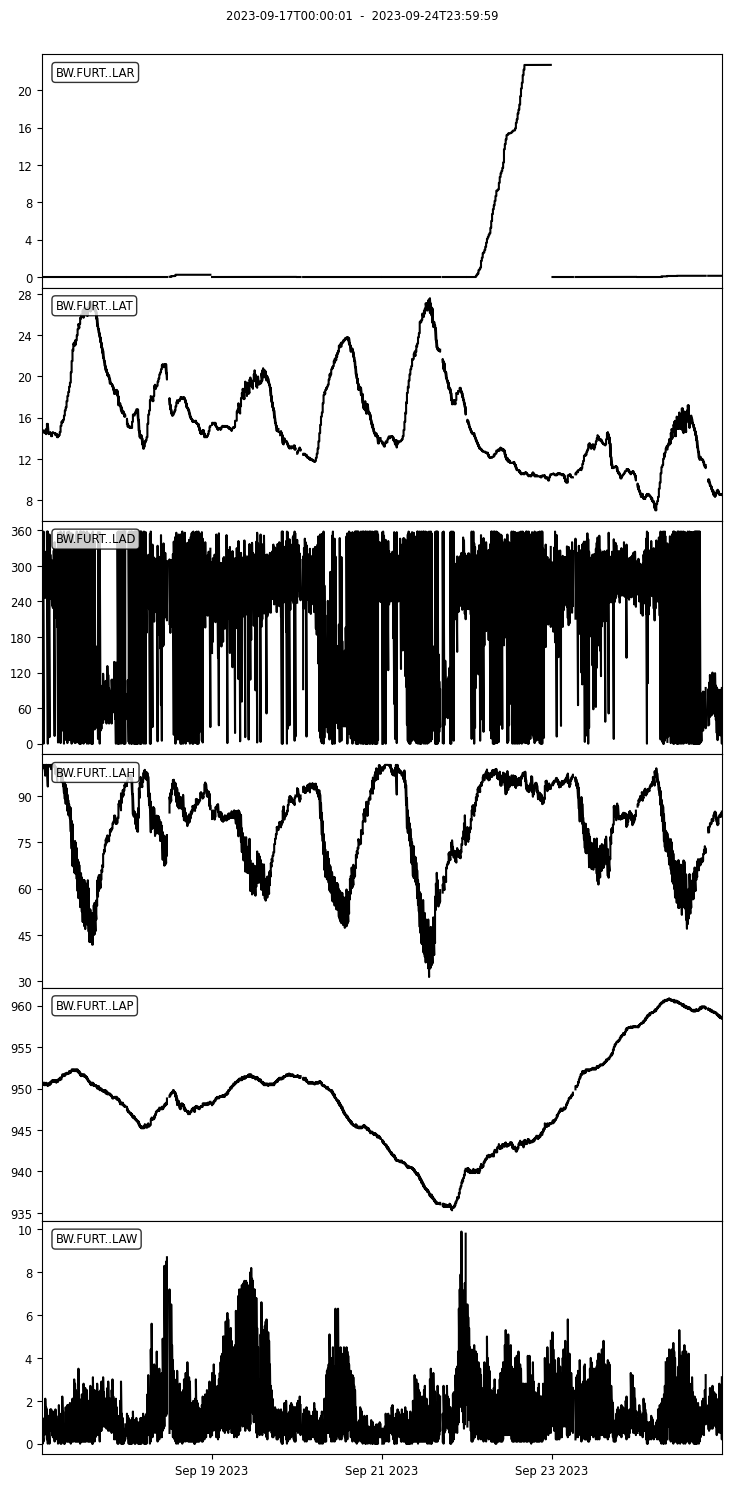

In [9]:
furt = __load_furt_stream(tbeg, tend, show_raw=False, sampling_rate=1.0)
furt.plot(equal_scale=False);

## Plot Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


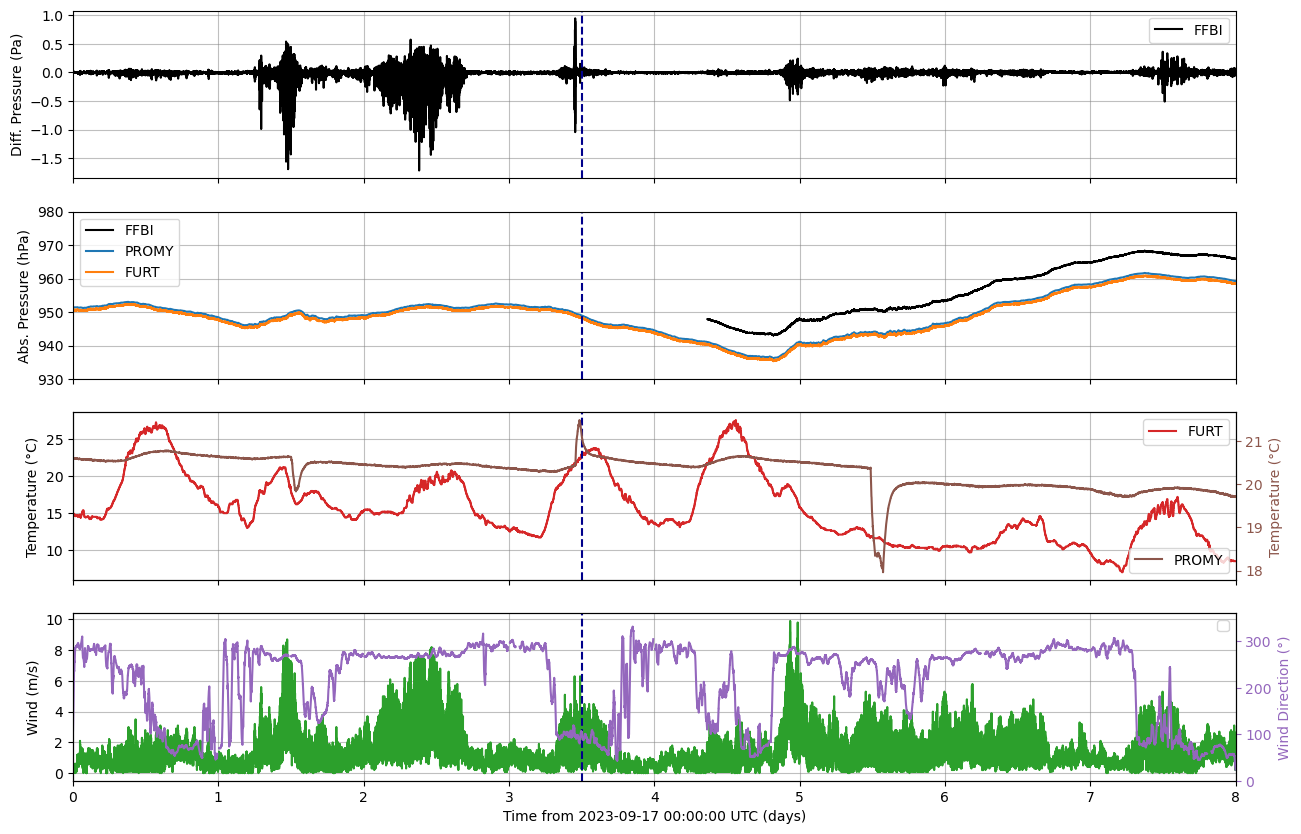

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(15,10), sharex=True)

def smooth(y, box_pts):
    from numpy import ones, convolve, zeros, array, concatenate
    box = ones(box_pts)/box_pts
    y = concatenate((zeros(box_pts), array(y), zeros(box_pts)))
    y_smooth = convolve(y, box, mode='same')
    return y_smooth[box_pts:-box_pts]


time_scaling = 86400

ax[0].plot(ffbi.select(channel="*F")[0].times()/time_scaling, ffbi.select(channel="*F")[0].data, label="FFBI", color="k")


ax[1].plot(ffbi.select(channel="*O")[0].times()/time_scaling, ffbi.select(channel="*O")[0].data*1000, label="FFBI", color="k")
ax[1].plot(promy.select(channel="LDI")[0].times()/time_scaling, promy.select(channel="LDI")[0].data/100, label="PROMY", color="tab:blue")
ax[1].plot(furt.select(channel="LAP")[0].times()/time_scaling, furt.select(channel="LAP")[0].data, label="FURT", color="tab:orange")


ax[2].plot(furt.select(channel="LAT")[0].times()/time_scaling, furt.select(channel="LAT")[0].data, label="FURT", color="tab:red")
ax22 = ax[2].twinx()
ax22.plot(promy.select(channel="LKI")[0].times()/time_scaling, promy.select(channel="LKI")[0].data, label="PROMY", color="tab:brown")
ax22.legend(loc=4)
ax22.tick_params(axis='y', colors="tab:brown")


ax[3].plot(furt.select(channel="LAW")[0].times()/time_scaling, furt.select(channel="LAW")[0].data, color="tab:green")
ax32 = ax[3].twinx()
wind_direction = smooth(furt.select(channel="LAD")[0].data, 1200)
ax32.plot(furt.select(channel="LAD")[0].times()/time_scaling, wind_direction, color="tab:purple")
ax32.set_ylim(0, 360)
ax32.tick_params(axis='y', colors="tab:purple")


ax22.set_ylabel("Temperature (°C)", color="tab:brown")
ax32.set_ylabel("Wind Direction (°)", color="tab:purple")
ax[0].set_ylabel("Diff. Pressure (Pa)")
ax[1].set_ylabel("Abs. Pressure (hPa)")
ax[2].set_ylabel("Temperature (°C)")
ax[3].set_ylabel("Wind (m/s)")

ax[3].set_xlabel(f"Time from {tbeg.date} {str(tbeg.time).split('.')[0]} UTC (days)")

for i in range(4):
    ax[i].grid(alpha=0.5, color="grey", zorder=0)
    ax[i].legend()
    ax[i].axvline((t_gravel-tbeg)/time_scaling, color="darkblue", ls="--")

ax[1].set_ylim(930, 980)
ax[3].set_xlim(0, max(promy.select(channel="LDI")[0].times()/time_scaling))

plt.show();

In [15]:
fig.savefig("/home/brotzer/Documents/ROMY/ROMY_infrasound/comparison_inlet_below_ground.png", dpi=200, format="png", bbox_inches='tight')